## 다이나믹 프로그래밍
다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [25]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states 모든 가능한 좌표 상태 리스트
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1


    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point 시작 시점
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point 목표 지점
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치 (trace에서 마지막 위치)

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)


    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]


    def state_after_action(self, state, action_idx:int): #현재 상태에서 행동 수행 후 도달 상태 반환
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state


    def check_boundary(self, state): # 격자 밖으로 나가지 않도록 상태 조정
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [26]:
env = GridWorldEnvironment(start_point=(0,0),
                           end_point=(4,4),
                           grid_world_size=(5,5))

# 01. 정책 이터레이션
- 정책 평가 (Policy Evaluation): 현재 정책에 따라 각 상태의 가치 `V(s)`를 계산
- 정책 개선 Policy Improvement): 현재 가치함수 `V(s)`에 기반해 더 나은 정책으로 업그레이드 -> 최적 행동을 찾기 위한 Q값 계산!

In [27]:
class PolicyIteration:
    def __init__(self,env):
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # 상태 가치 함수 전부 0으로 초기화
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist()

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화 (0.25)
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율


    def get_policy(self, state): # 특정 상태에서의 정책 반환
        return self.policy_table[state[0]][state[1]]


    def get_value(self, state): # 특정 상태에서의 가치 함수 값 반환
        return self.value_table[state[0]][state[1]]


    def get_action(self,state): # 주어진 상태에서 정책에 따라 확률적으로 행동 선택
        policy = self.get_policy(state) # 특정 상태에서의 정책
        action = np.random.choice(range(len(self.action_space)), p=policy)
        return action


    def policy_evaluation(self): # 정책 평가
        for state in self.env.total_states:
            # 벨만 기대 방정식을 이용해 현재 정책에 대한 각 state의 가치를 구하기
            state_value = 0.0

            if state == self.env.end_point: # 종료 상태인 경우 V(s)=0
                self.value_table[state[0]][state[1]] = 0.0

            else: # 현재 정책에 따라 각 상태 가치를 벨만 기대 방정식으로 계산
                state_policy = self.get_policy(state) # 그 외

                for action_idx in range(self.num_action):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)

                    state_value += state_policy[action_idx] * (reward + self.gamma*next_value) # 현재 정책에서의 기댓값 계산
                    # state_value += π(a|s) × [R(s,a) + γ V(s')
                    # (정책에서 해당 행동을 선택할 확률) X (보상 + 미래 가치의 기댓값)
                self.value_table[state[0]][state[1]] = state_value


    def policy_improvement(self): # 정책 개선 - 현재 가치 함수에 기반하여 탐욕적 정책 선택
        next_policy = self.policy_table

        for state in self.env.total_states:
            q_value_list = []

            # 반환할 정책 초기화
            result = np.zeros(shape=(self.num_action)).tolist()

            for action_idx in range(self.num_action):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)

                q_value = reward + self.gamma * next_value
                # q_value = R(s,a) + γ V(s')
                # 현재 가치 함수 기준으로 어떤 행동이 좋은지 각 행동 Q값 개별 계산
                q_value_list.append(q_value)

            # 받을 보상이 최대인 행동들에 대한 탐욕 정책 발전
            max_value = np.max(q_value_list)
            max_indices = np.where(q_value_list == max_value)[0]

            # 최댓값이 여러 개일 때 확률을 나누기 위해
            prob = 1 / len(max_indices)

            for max_idx in max_indices:
                result[max_idx] = prob

            next_policy[state[0]][state[1]] = result

        self.policy_table = next_policy


## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [28]:
pi = PolicyIteration(env) # 객체 생성

ITERATIONS = 15
VISUALIZE = True # 시각화 여부
total_moves = [] # 각 반복에서 목표 지점까지 도달하는 데 걸린 이동 수 기록

In [29]:
for iter in range(ITERATIONS):
    move_cnt = 0
    env.traces = [] # 이전 이동 경로 초기화
    state = env.start_point # 시작 위치 초기화

    pi.policy_evaluation()
    pi.policy_improvement()

    while state != env.end_point:
        action_idx = pi.get_action(state) # 현재 정책에 따라 행동 선택
        next_state = env.state_after_action(state, action_idx) # 다음 상태 계산
        state = next_state

        env.traces.append(state) # 에이전트 위치 업데이트
        move_cnt += 1 # 이동 횟수 + 1

    total_moves.append(move_cnt) # 걸린 이동 수를 저장 및 출력

    print(f"ITERATION: {iter+1} / {ITERATIONS} __ move_cnt : {move_cnt}")

    if VISUALIZE:
        env.render()

ITERATION: 1 / 15 __ move_cnt : 49
S X X X X 
X X X X X 
. . . . X 
. . . . X 
. . . . A 

ITERATION: 2 / 15 __ move_cnt : 30
S X X X . 
X X . X . 
. X . . . 
. X X . . 
. . X X A 

ITERATION: 3 / 15 __ move_cnt : 12
S X X X X 
X . . . X 
. . . . X 
. . . . X 
. . . . A 

ITERATION: 4 / 15 __ move_cnt : 11
S . . . . 
X . . . . 
X . . . . 
X X . . . 
. X X X A 

ITERATION: 5 / 15 __ move_cnt : 10
S . . . . 
X X . . . 
. X X X . 
. . . X X 
. . . . A 

ITERATION: 6 / 15 __ move_cnt : 10
S X X . . 
. . X X X 
. . . . X 
. . . . X 
. . . . A 

ITERATION: 7 / 15 __ move_cnt : 8
S . . . . 
X X . . . 
. X X . . 
. . X X X 
. . . . A 

ITERATION: 8 / 15 __ move_cnt : 8
S . . . . 
X X . . . 
. X . . . 
. X X X X 
. . . . A 

ITERATION: 9 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X X X X 
. . . . X 
. . . . A 

ITERATION: 10 / 15 __ move_cnt : 8
S . . . . 
X . . . . 
X X . . . 
. X . . . 
. X X X A 

ITERATION: 11 / 15 __ move_cnt : 8
S X . . . 
. X . . . 
. X . . . 
. X . . . 
. X X X A 

IT

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

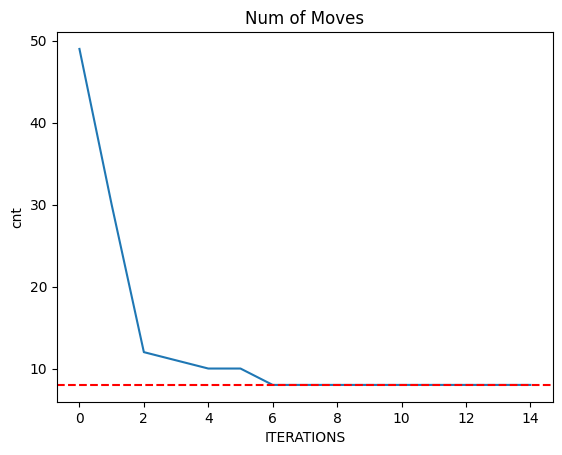

In [31]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle='--') # 목표에 도달하는 데 걸린 이동 수 기록
# 얼마나 빠르게 정책이 개선되고 수렴되는지 시각적으로 분석
plt.ylabel("cnt")
plt.xlabel("ITERATIONS")
plt.title("Num of Moves")
plt.show()

에이전트가 start에서 end까지 도달하는데 걸리는 이동 수가 대략 5~6회로 수렴함을 알 수 있다.
- 첫 iteration에 50회가 걸린 것에 비해 많이 줄었음
- 이동 수가 줄어들었다는 것은 그만큼 더 효율적인 경로로 목표에 도달하고 있다는 것!
- 정책이 더 "좋은 결정"을 하고 있음을 알 수 있다
- 정책이 최적 경로를 잘 학습했다

In [32]:
# 정책 테이블 표현하기 - 각 상태에서 어떤 행동을 어떤 확률로 택하는지 보여줌
policy_table_df = pd.DataFrame()

for x in range(env.width):
    for y in range(env.height):
        policy_table_df[f"({x},{y})"] = pi.policy_table[x][y]

policy_table_df = policy_table_df.T
col_names = dict(zip(range(len(env.action_space)), env.action_space)) # 행동 이름으로 열 이름 바꾸기
policy_table_df.rename(columns=col_names, inplace=True)
policy_table_df

,up,down,left,right
"(0,0)",0.0,0.5,0.0,0.5
"(0,1)",0.0,0.5,0.0,0.5
"(0,2)",0.0,0.5,0.0,0.5
"(0,3)",0.0,0.5,0.0,0.5
"(0,4)",0.0,1.0,0.0,0.0
"(1,0)",0.0,0.5,0.0,0.5
"(1,1)",0.0,0.5,0.0,0.5
"(1,2)",0.0,0.5,0.0,0.5
"(1,3)",0.0,0.5,0.0,0.5
"(1,4)",0.0,1.0,0.0,0.0


가장 마지막 iteration에서 학습된 pi.policy_table을 기반으로 정책을 시각화 한 것!

# 02. 가치 이터레이션
- 정책 평가, 정책 개선 2 단계를 합쳐서 한 번에 `V(s)`를 최적 가치로 갱신

In [33]:
class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # 상태 가치 함수 전부 0으로 초기화
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율


    def value_iteration(self):
        for state in self.env.total_states:

            if state == self.env.end_point:
                self.value_table[state[0]][state[1]] = 0.0

            else:
                q_value_list = []
                # 벨만 최적 방정식
                for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    q_value = reward + self.gamma * next_value
                    q_value_list.append(q_value)

                # 최댓값을 다음 가치함수로 대입
                self.value_table[state[0]][state[1]] = max(q_value_list)


    def get_action(self, state): # 정책 추출
        if state == self.env.end_point:
            return []

        else:
            q_value_list = []
            # q_value = R(s,a) + γ V(s')
            for action_idx in range(self.num_actions):
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                q_value = reward + self.gamma * next_value
                q_value_list.append(q_value)

            max_value = np.max(q_value_list)
            max_indices = np.where(q_value_list == max_value)[0]
            action_idx = np.random.choice(max_indices) # 가장 큰 값들을 구하고, 무작위로 하나 선택
            # return max_indices
            return action_idx


    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [34]:
vi = ValueIteration(env)

ITERATIONS = 15
VISUALIZE = True
total_moves = []

In [35]:
for iter in range(ITERATIONS):
    move_cnt = 0
    env.traces = [] # 이동 경로 초기화
    state = env.start_point # 시작 위치 초기화

    vi.value_iteration() # 정책을 명시적으로 저장하지 않고 V(s)만으로 최적 행동을 유도

    while state != env.end_point:
        action_idx = vi.get_action(state) # 현재 상태에서 Q(s,a)를 계산하고, 최적 행동 선택
        next_state = env.state_after_action(state, action_idx) # 행동에 따른 다음 상태 계산
        state = next_state

        env.traces.append(state)
        move_cnt += 1 # 이동한 횟수 + 1

    total_moves.append(move_cnt)

    print(f"ITERATIONS: {iter+1} / {ITERATIONS} __ move_cnt : {move_cnt}")

    if VISUALIZE:
        env.render()

ITERATIONS: 1 / 15 __ move_cnt : 31
S . . . . 
X X X . . 
X X X . . 
. X X . . 
X X X X A 

ITERATIONS: 2 / 15 __ move_cnt : 35
S X X X . 
X X X X X 
X X X . X 
. . . . X 
. . . . A 

ITERATIONS: 3 / 15 __ move_cnt : 14
S X . . . 
X X . . . 
X X . . . 
. X X . . 
. . X X A 

ITERATIONS: 4 / 15 __ move_cnt : 11
S X X X X 
. . . . X 
. . . . X 
. . . . X 
. . . . A 

ITERATIONS: 5 / 15 __ move_cnt : 13
S . . . . 
X X . . . 
. X . . . 
. X . . . 
. X X X A 

ITERATIONS: 6 / 15 __ move_cnt : 9
S . . . . 
X X X X X 
. . . . X 
. . . . X 
. . . . A 

ITERATIONS: 7 / 15 __ move_cnt : 8
S . . . . 
X X . . . 
. X . . . 
. X X . . 
. . X X A 

ITERATIONS: 8 / 15 __ move_cnt : 8
S . . . . 
X X X . . 
. . X X X 
. . . . X 
. . . . A 

ITERATIONS: 9 / 15 __ move_cnt : 8
S . . . . 
X X . . . 
. X X . . 
. . X X . 
. . . X A 

ITERATIONS: 10 / 15 __ move_cnt : 8
S . . . . 
X . . . . 
X . . . . 
X . . . . 
X X X X A 

ITERATIONS: 11 / 15 __ move_cnt : 8
S X X . . 
. . X . . 
. . X . . 
. . X . . 
. . 

## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

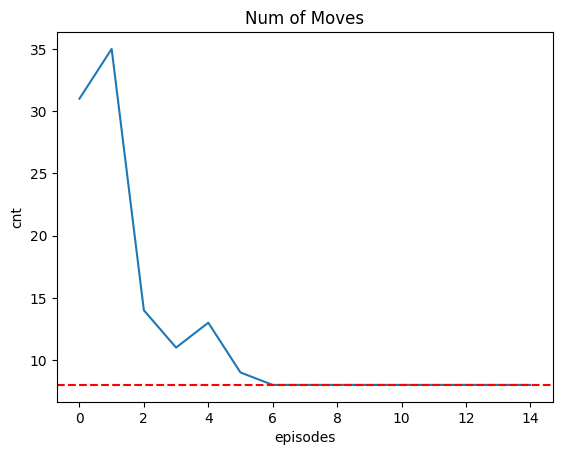

In [36]:
plt.plot(total_moves)
plt.axhline(y=min(total_moves), color='r', linestyle='--')
plt.ylabel("cnt")
plt.xlabel("episodes")
plt.title("Num of Moves")
plt.show()

In [37]:
# 가치 테이블
np.array(vi.value_table).round(3)

array([[0.478, 0.531, 0.59 , 0.656, 0.729],
       [0.531, 0.59 , 0.656, 0.729, 0.81 ],
       [0.59 , 0.656, 0.729, 0.81 , 0.9  ],
       [0.656, 0.729, 0.81 , 0.9  , 1.   ],
       [0.729, 0.81 , 0.9  , 1.   , 0.   ]])

현재까지 학습된 `V(s)`를 정리해서 보여줌
- 숫자가 클수록 해당 상태에서 시작했을 때 얻을 수 있는 기대 보상이 높다는 뜻
- 특히 목표 지점에 가까운 상태일수록 가치가 더 클 것

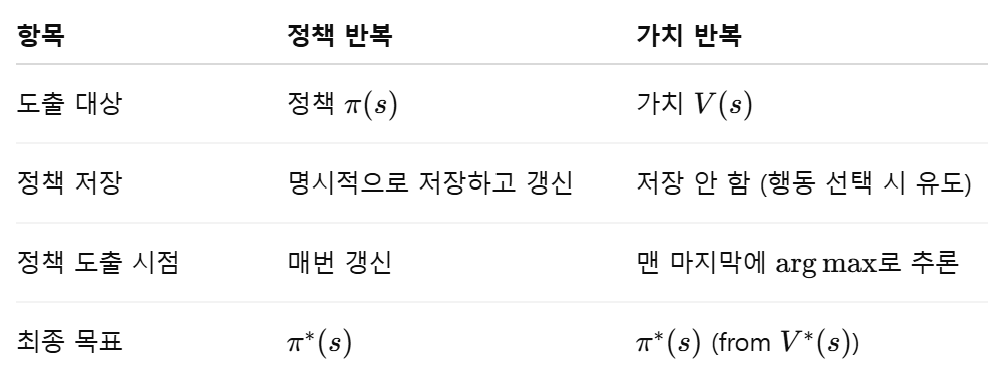